# Computer Vision and Deep Learning 
## Lab 1 - Kinect 

The following notebook provides functionality which connects to the `CVDL_Server.ipynb` notebook to obtain frames from the KinectV2 over TCP/IP. 

__This is the notebook you are expected to run once the server notebook is running.__

Check the IP address of the machine that `CVDL_Server.ipynb` is running on and update `server_ip` in the section on [opening a socket](#open_socket).

## Imports <a id="imports"></a>
The following section defines the imports used for the rest of the notebook.

In [1]:
# For ndarray handling:
import numpy as np

# For plotting:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [9, 10]

# For TCP/IP functionality:
from struct import unpack
import socket

## Open a TCP/IP connection and grab data from the remote KinectV2 <a id="open_socket"></a>
The following section creates a new socket connection which allows for connection to `CVDL_Server`. We then enter a for loop which looks to obtain the requested number of frames from the server. This section retrieves the provided image, depth and infrared frames from the KinectV2 as byte streams.

In [2]:
server_ip = '137.44.6.201' # Edit this to reflect the correct IP address
server_port = 20156
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((server_ip, server_port))


n_frames = 10 # Edit this to select your number of requested frames
img = []
dep = []
infra = []

print('Getting frames:')
s.send(bytes([n_frames]))
for i_frame in range(n_frames):
    
    #Color
    msg_size = s.recv(8)
    (msg_size,) = unpack('>Q', msg_size)
    data = b''
    while len(data) < msg_size:
        left_to_read = msg_size - len(data)
        data += s.recv(4096 if left_to_read > 4096 else left_to_read)
    #data = data[:BUFFERSIZE]
    img.append(np.frombuffer(data, np.uint8))
    s.send(b'1')
    
    #Depth
    msg_size = s.recv(8)
    (msg_size,) = unpack('>Q', msg_size)
    data = b''
    while len(data) < msg_size:
        left_to_read = msg_size - len(data)
        data += s.recv(4096 if left_to_read > 4096 else left_to_read)
    #data = data[:BUFFERSIZE]
    dep.append(np.frombuffer(data, np.uint16))
    s.send(b'1')
    
    #Infrared
    msg_size = s.recv(8)
    (msg_size,) = unpack('>Q', msg_size)
    data = b''
    while len(data) < msg_size:
        left_to_read = msg_size - len(data)
        data += s.recv(4096 if left_to_read > 4096 else left_to_read)
    #data = data[:BUFFERSIZE]
    infra.append(np.frombuffer(data, np.uint8))
    s.send(b'1')
    
    print('Frame {0} done'.format(i_frame))
    
print('Finished grabbing data from server.')
s.close()

Getting frames:
Frame 0 done
Frame 1 done
Frame 2 done
Frame 3 done
Frame 4 done
Frame 5 done
Frame 6 done
Frame 7 done
Frame 8 done
Frame 9 done
Finished grabbing data from server.


## Reshape the data packets into 2D maps
The byte streams coming in over the TCP/IP connection are a flattened form of the color, depth and infrared maps captured by the KinectV2. We therefore want to reshape these vectors into their original shapes. For the color maps we require a `Height` $\times$ `Width` $\times$ `Channel` ndarray, depth and infrared maps both require a `Height` $\times$ `Width` ndarray.

The native KinectV2 color map resolution is `Height`: 1920, `Width`: 1080 and `Channel`: 4 (BGRA - Blue, Green, Red, Alpha). However for the purpose of consistent map sizes and data transfer, we downsample our maps to be `Height`: 1920 // 2, `Width`: 1080 // 2 for all 3 data streams.

Notice that the Kinect returns the color channels in BGRA order. For `matplotlib`'s image plotting functionality we will want to pass the channels in RGB order, for this we slice into our color map and reorder the channel dimension with `[:, :, [2, 1, 0]]`

In [3]:
# Reshape the frames
IMGW = 1920 // 2 # Image width
IMGH = 1080 // 2 # Image Height

img = [np.reshape(elem,(IMGH, IMGW, 4))[: ,: ,[2, 1, 0]] for elem in img]
dep = [np.reshape(elem,(IMGH, IMGW)) for elem in dep]
infra = [np.reshape(elem,(IMGH, IMGW)) for elem in infra]


## Plot frames
In this following section we want to plot the color, depth and infrared maps we have collected from the KinectV2. 

Note that these maps do not match eachother exactly, pixels within the color map do not correspond directly to the corresponding pixel in the depth and infrared maps. The sensors on the KinectV2 are mounted at opposite ends of the sensor bar, and have differing resolutions and fields of view. 

This difference in viewpoint means that in order to align (or more formally ''register'') the color to the depth map we need to calculate the intrinsic and extrinsic parameters of the numerous Kinect sensors, we will cover this in the coming labs.

<IPython.core.display.Javascript object>


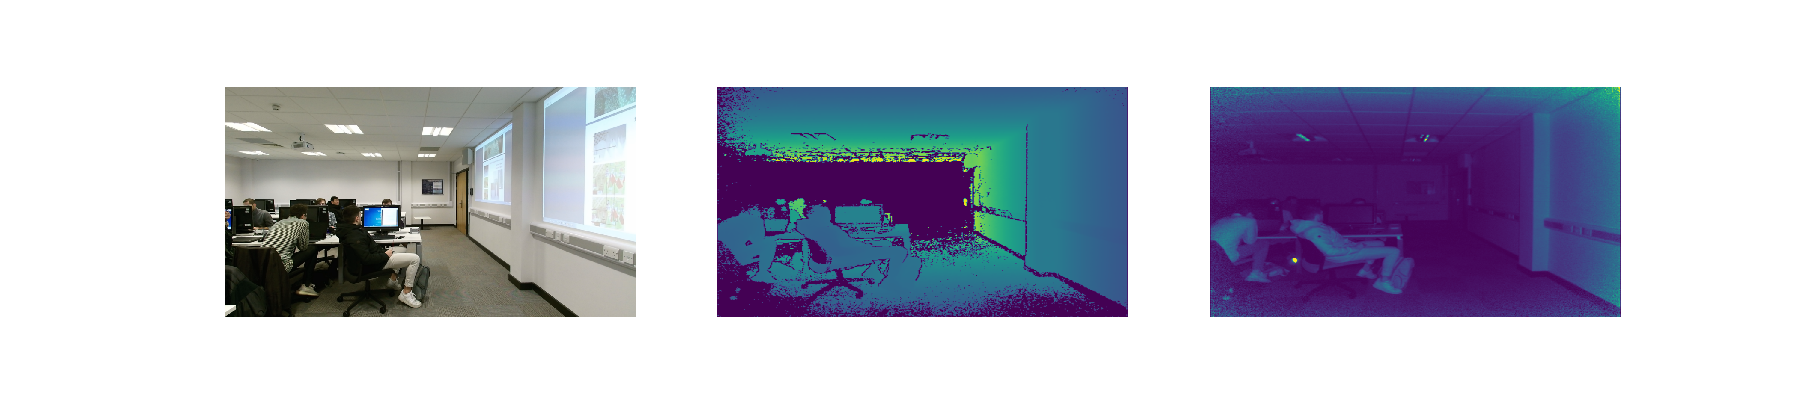

<IPython.core.display.Javascript object>


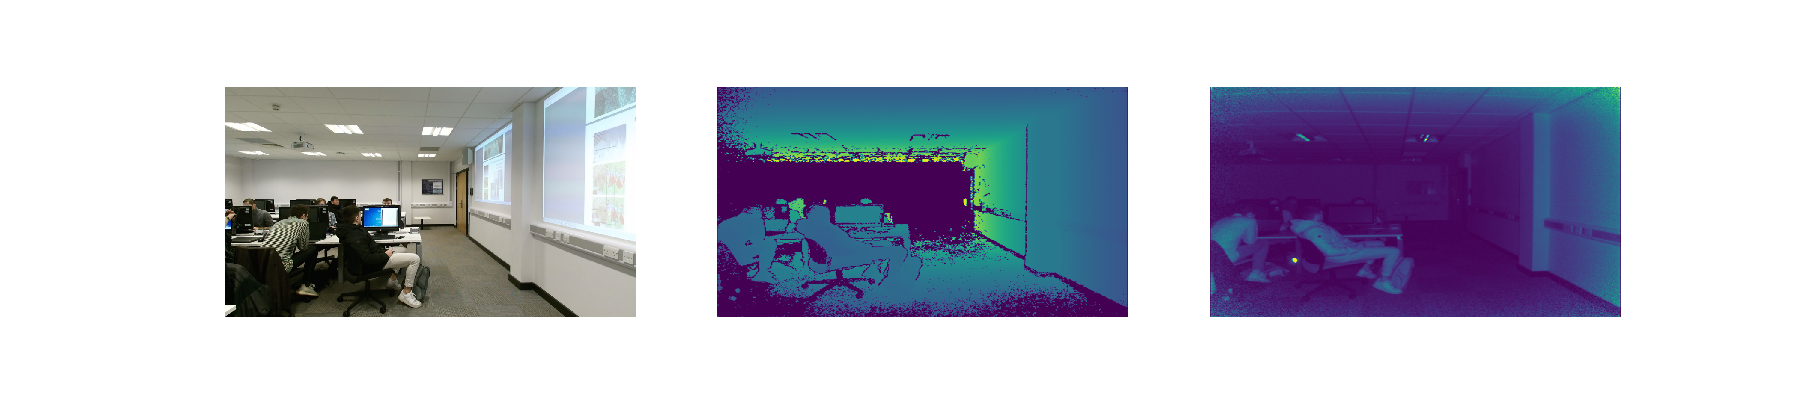

<IPython.core.display.Javascript object>


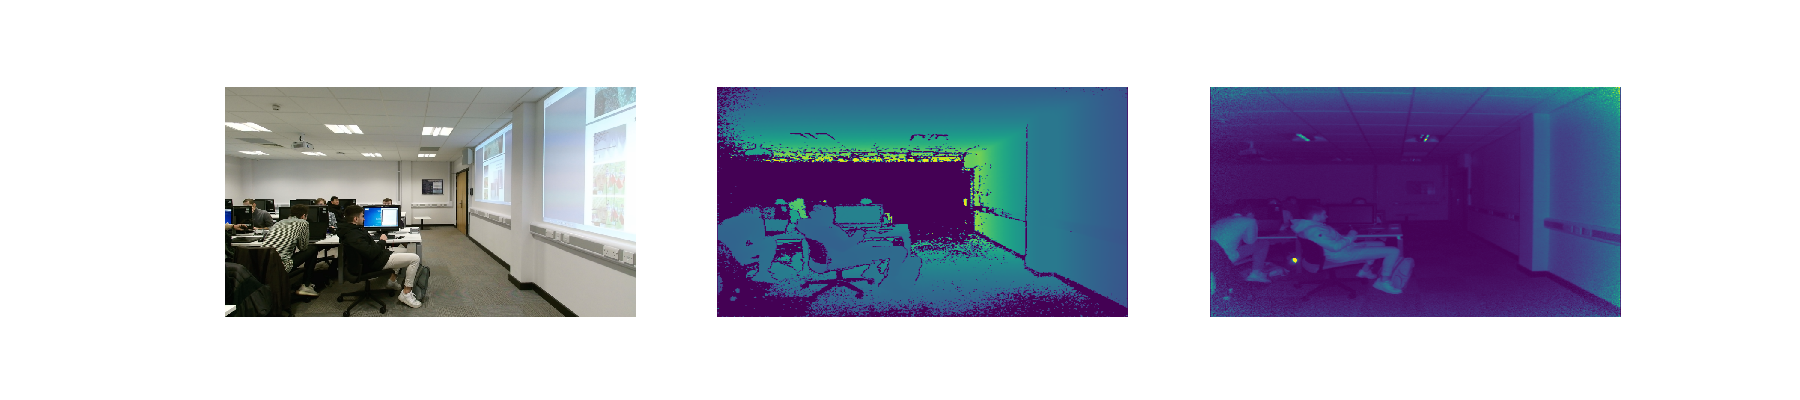

<IPython.core.display.Javascript object>


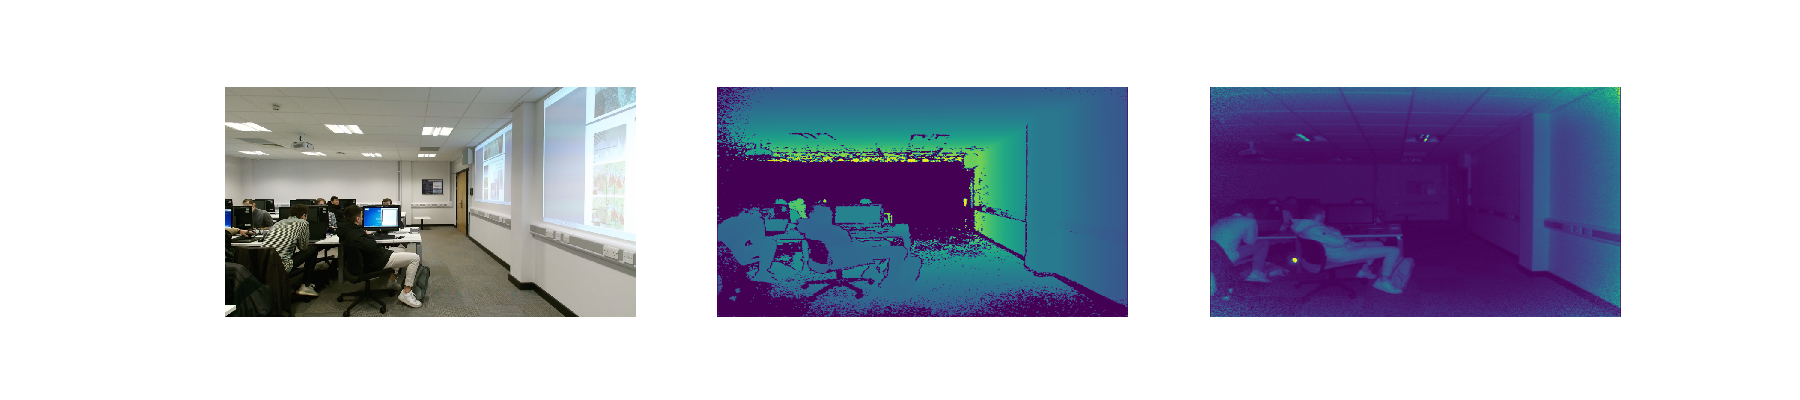

<IPython.core.display.Javascript object>


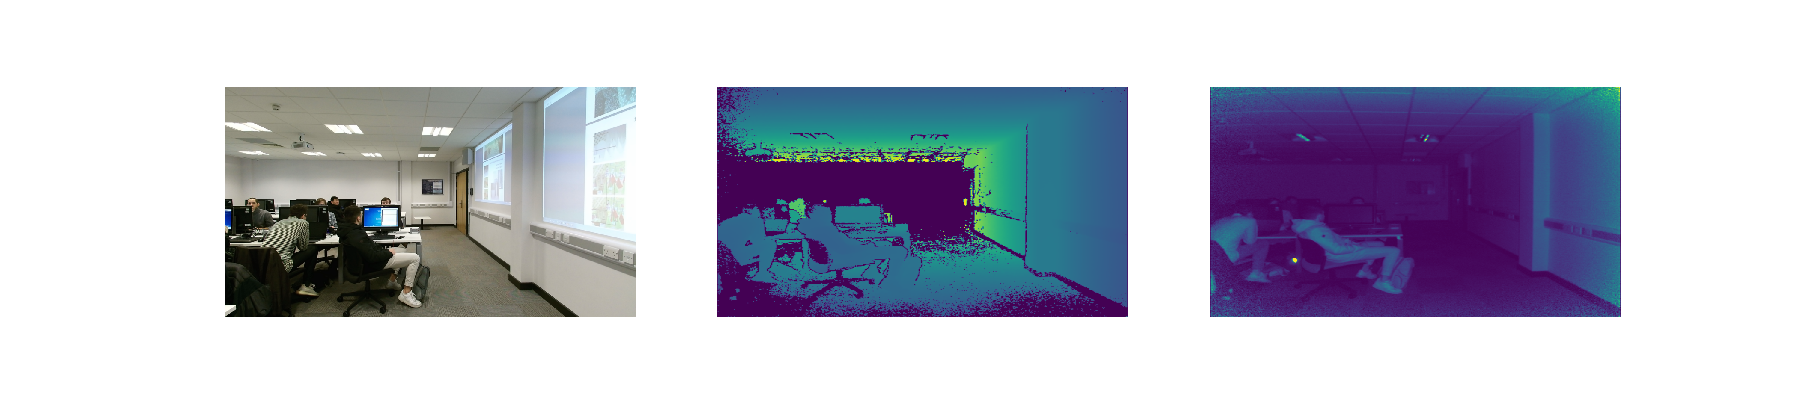

<IPython.core.display.Javascript object>


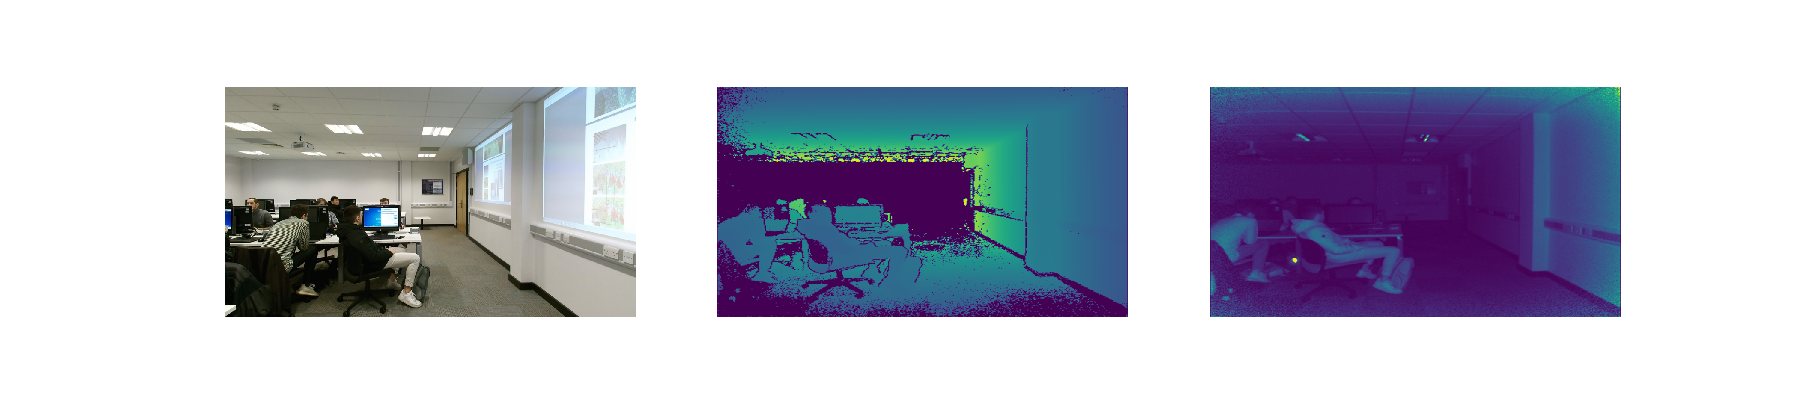

<IPython.core.display.Javascript object>


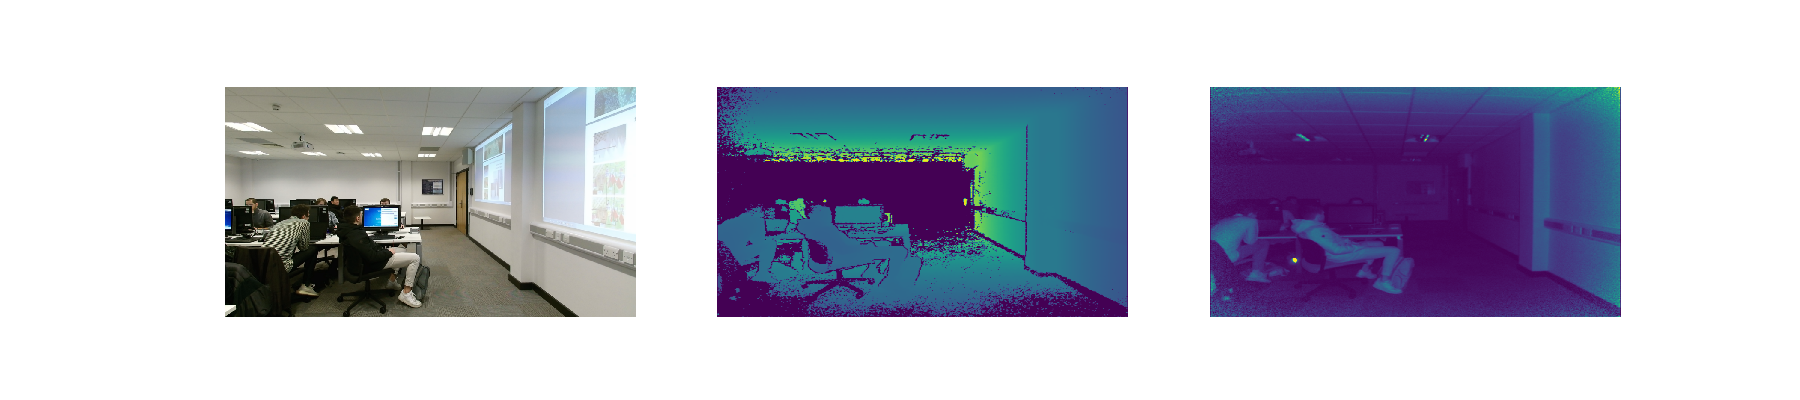

<IPython.core.display.Javascript object>


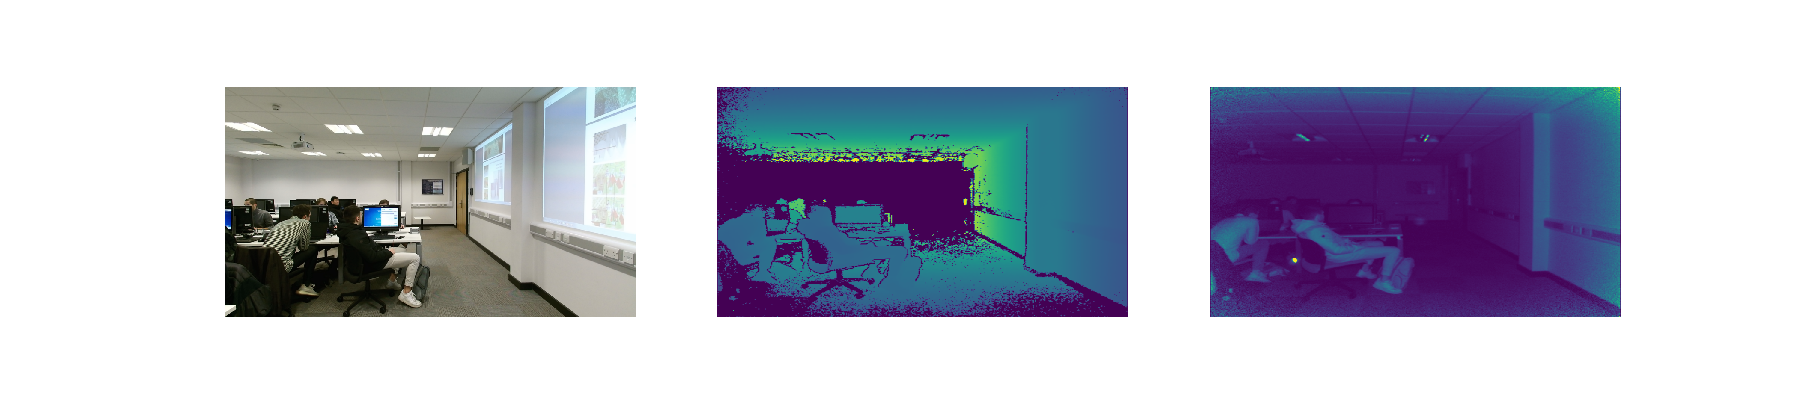

<IPython.core.display.Javascript object>


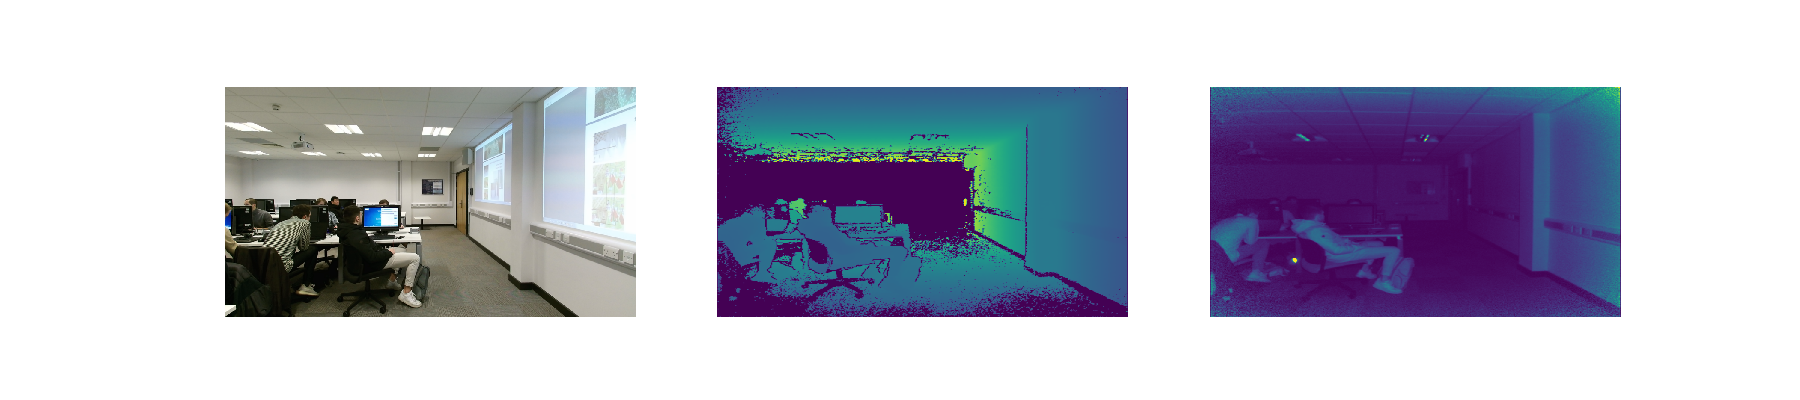

<IPython.core.display.Javascript object>


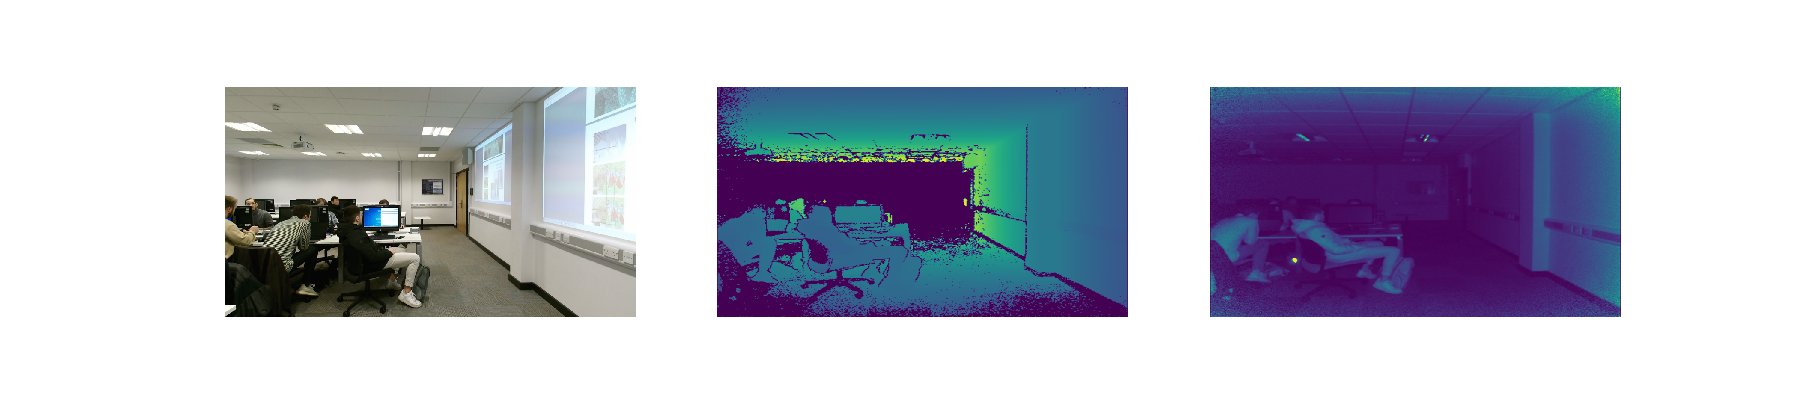

In [4]:
# Loop over our captured frames, and subplot each map 
for i_frame in range(n_frames):
    fig = plt.figure(figsize=[9, 2])
    plt.subplot(131)
    plt.imshow(img[i_frame])
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(dep[i_frame])
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(infra[i_frame])
    plt.axis('off')
    plt.show(block=False)

## Plot 3D pointcloud
The following section produces a XYZ pointcloud of the depth map information. It looks okay, however if we look at the second plot, where we also visualize the color map information at these locations, we can see that the two maps are not aligned.

<IPython.core.display.Javascript object>


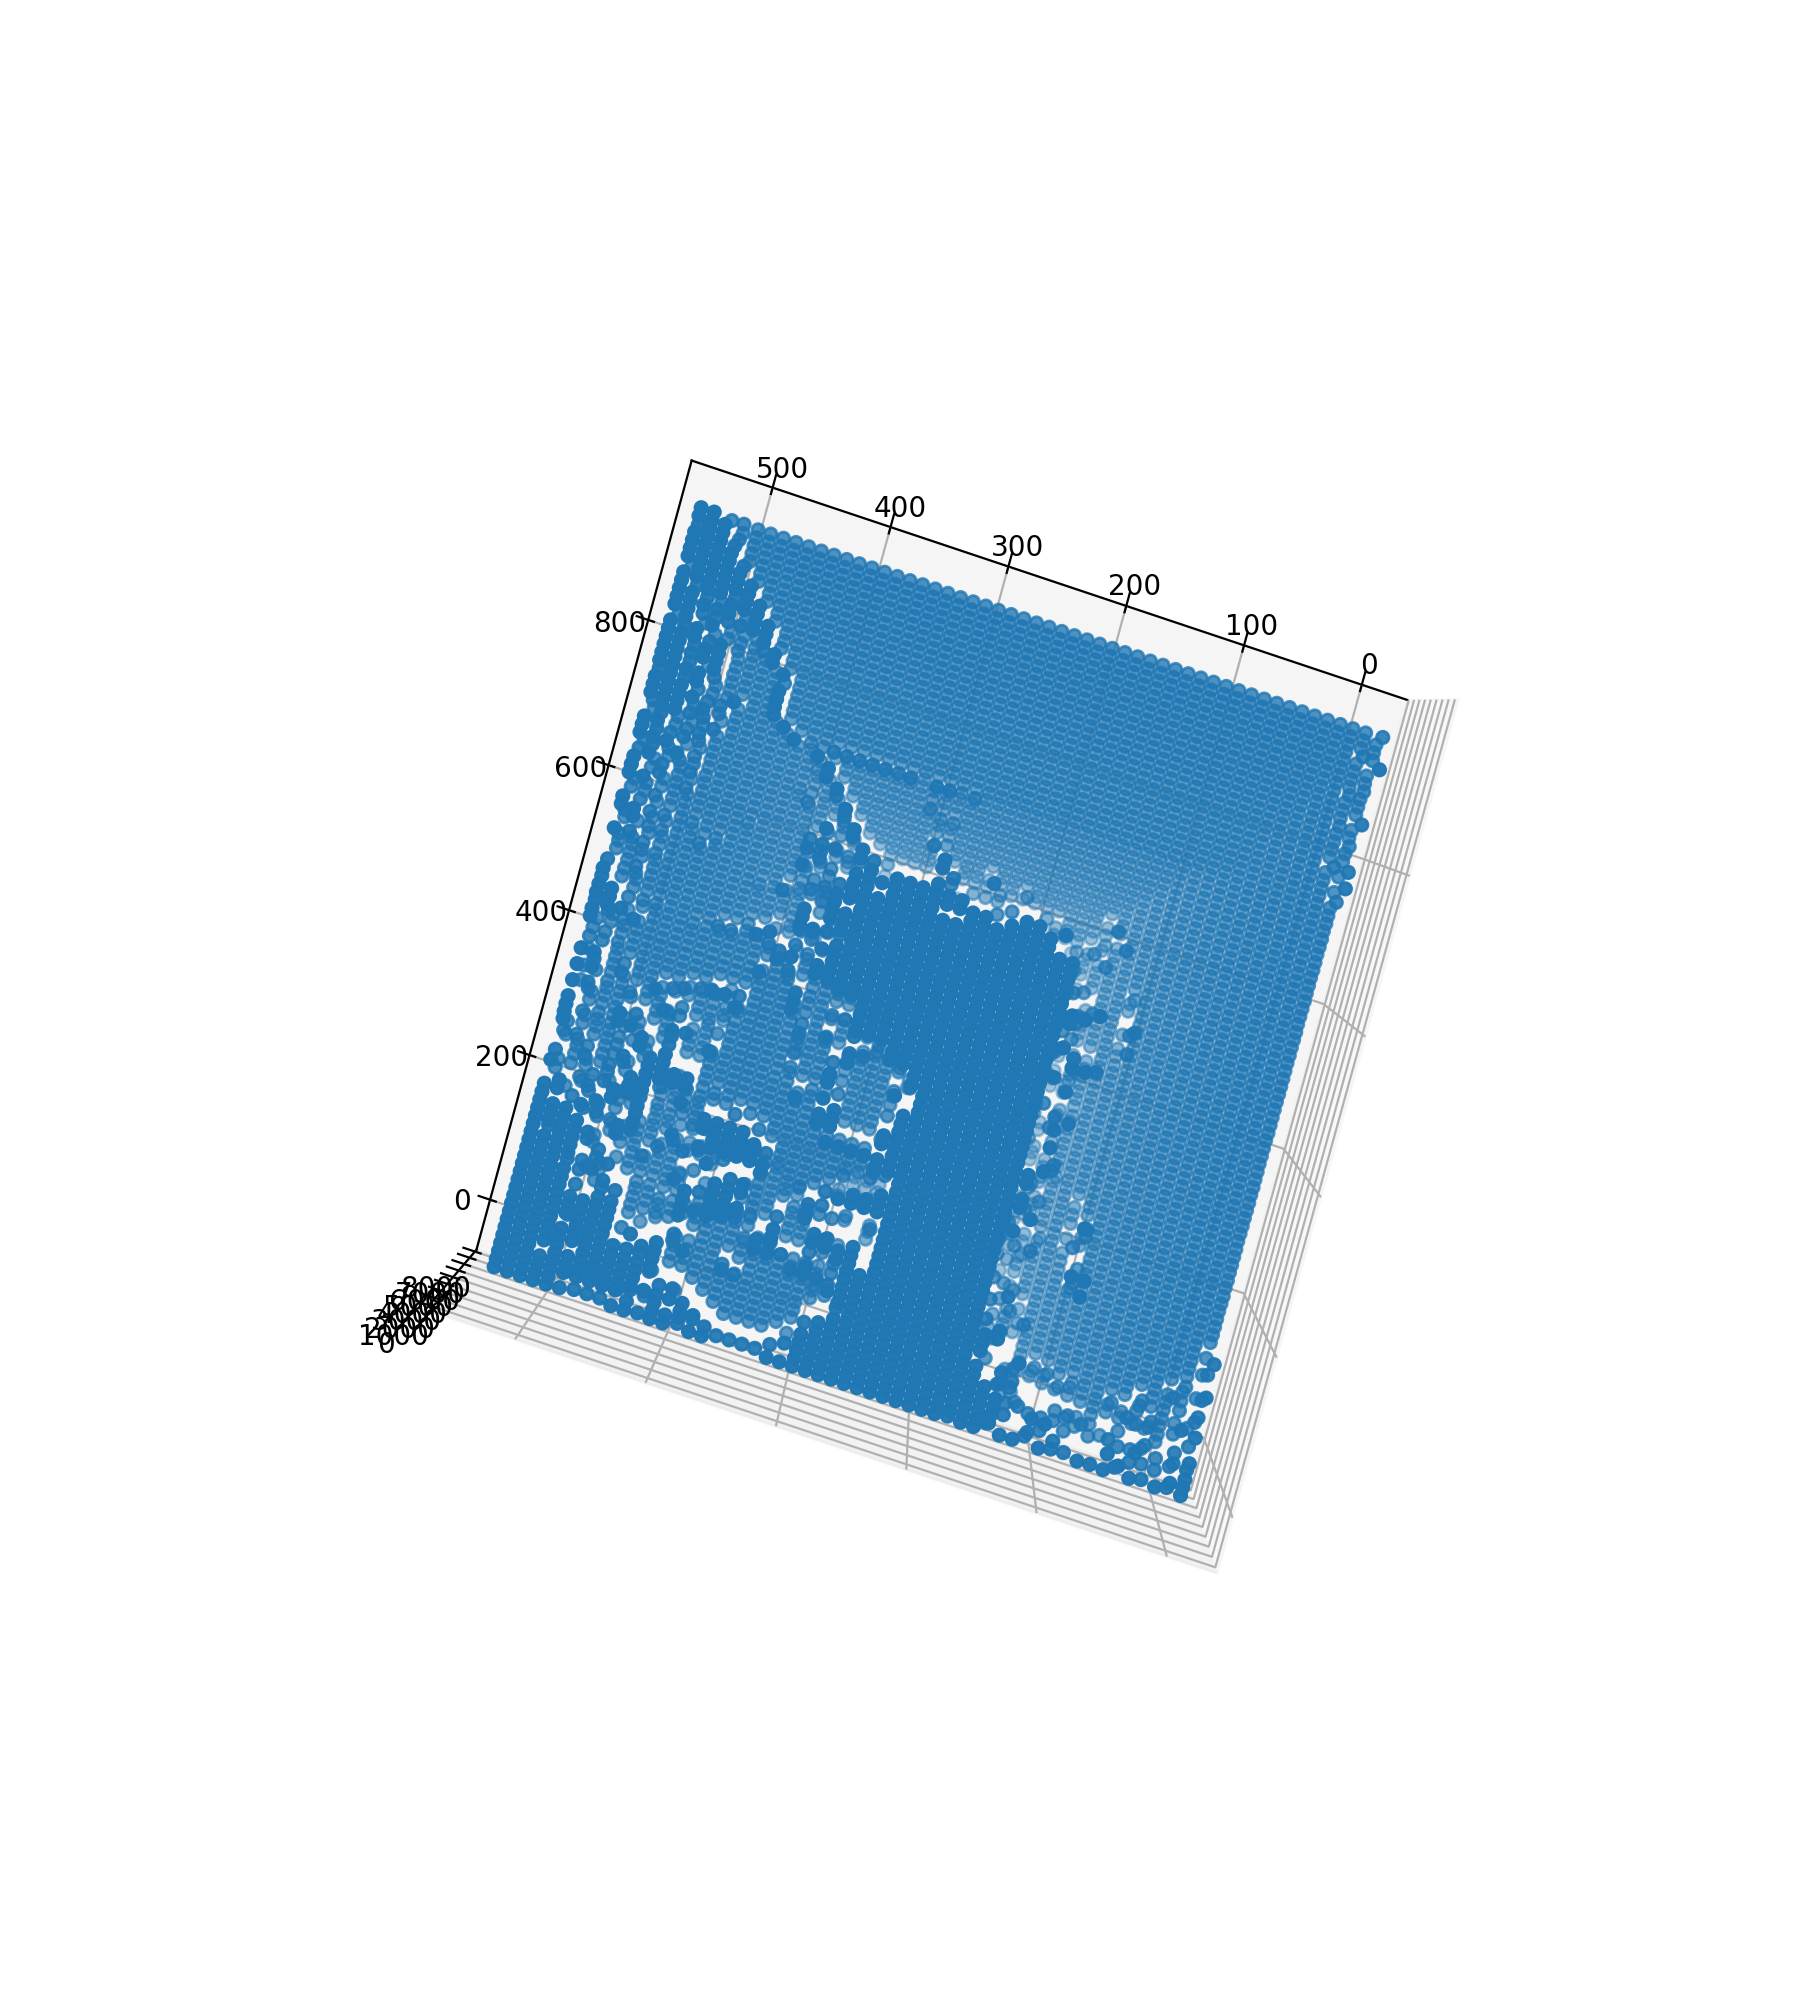

<IPython.core.display.Javascript object>


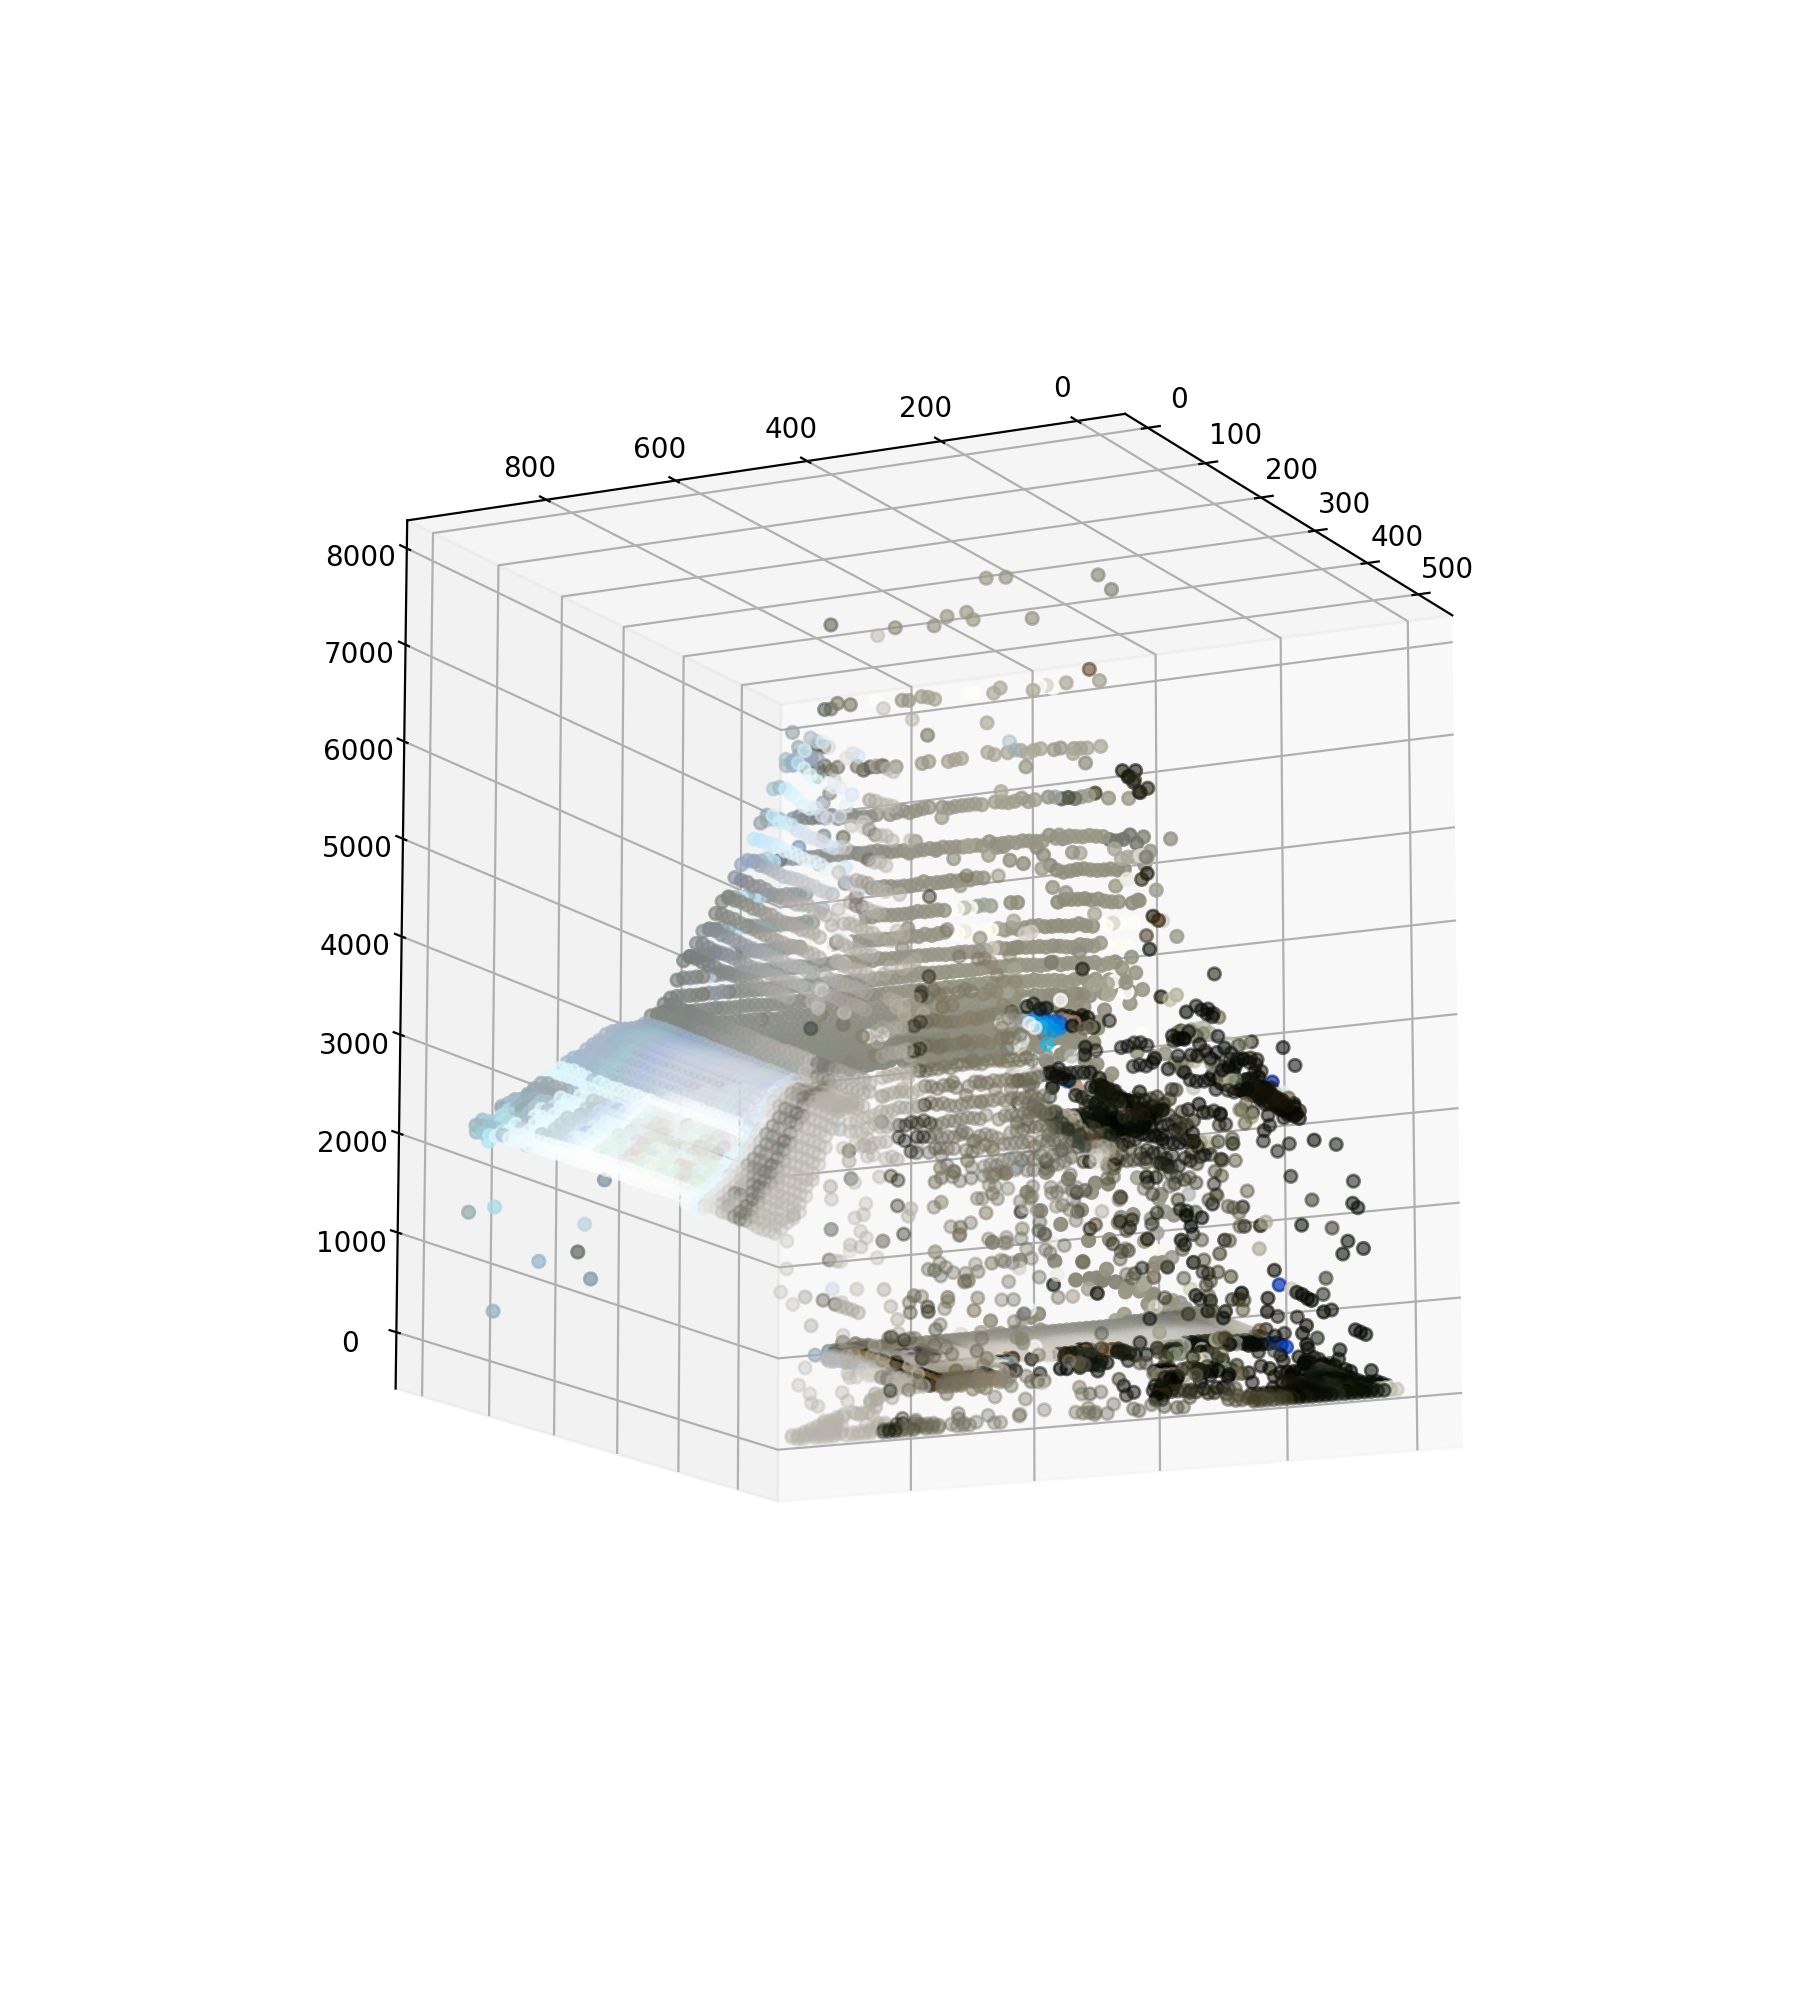

In [5]:
# Choose a frame to plot, and a spatial subsampling of our maps to reduce the number of points plotted
i_frame = 3
subsampling_interval = 10
ys, xs = np.meshgrid(np.arange(0, IMGW, subsampling_interval), 
                     np.arange(0, IMGH, subsampling_interval))

# Just the XYZ information
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=xs.flatten(), ys=ys.flatten(), 
           zs=dep[i_frame][0::subsampling_interval,0::subsampling_interval].flatten())
plt.show(block=False)

# Naive RGB-Depth pointcloud, note the disparity between the color and depth
# We will look to fix that in the coming labs via registration
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=xs.flatten(), ys=ys.flatten(), 
           zs=dep[i_frame][0::subsampling_interval,0::subsampling_interval].flatten(),
           c=np.reshape(img[i_frame][0::subsampling_interval,0::subsampling_interval],(-1, 3))/255)
plt.show(block=False)

# Challenge Tasks

1) https://github.com/Kinect/PyKinect2
2) A Lasso gesture is .......
3a)
3b) 
3c)
4)
4b) 